In [16]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import torch
import os
import zipfile

#%matplotlib widget

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import sys
jupyter_session = 'ipykernel' in sys.modules

### Tuning Parameters

In [17]:
num_classes      = 10
num_epochs       = 10
lr               = 0.001
n_PCA_components = 40

# n_PCA_components        =  10 -> 77[%] accuracy
# n_PCA_components        =  25 -> 80[%] accuracy
# n_PCA_components        =  35 -> 86[%] accuracy
# n_PCA_components        =  40 -> 91[%] accuracy  <---- preferred dimensionality reduction
# n_PCA_components        =  45 -> 82[%] accuracy
# n_PCA_components        =  50 -> 87[%] accuracy
# n_PCA_components        =  60 -> 82[%] accuracy
# n_PCA_components        =  75 -> 84[%] accuracy
# n_PCA_components        = 100 -> 71[%] accuracy

# "raw" data, no dim. reduction -> 95[%] accuracy

### Load tsv files

In [18]:
## Load gtex samples
gtex_file   = 'gtex_gene_small' # 1000 gtex samples
annot_file  = 'gtex_annot'      # gtex id <-> tissue

data_path   = '../data/'
gtex_path   = data_path + gtex_file  + '.tsv'
annot_path  = data_path + annot_file + '.tsv'
zip_path    = data_path + gtex_file  + '.zip'

# Check if .tsv file exists
if not os.path.exists(gtex_path):
    print(f'"{gtex_path}" not found.')
    # Check if .zip file exists
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f'Neither {gtex_path} nor {zip_path} were found.')
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print(f'Unzipping "{zip_path}"')
        zip_ref.extractall(data_path)
        print('Done.')

# Read decompressed .tsv file
print(f'Reading "{gtex_path}"')
gtex_csv = pd.read_csv(gtex_path, sep='\t', header=0)
print('Done.')

## Load annotation/tissue file
print(f'Reading "{annot_path}"')
gtex_annot_csv = pd.read_csv(annot_path, sep='\t', header=0)
print('Done.')

Reading "../data/gtex_gene_small.tsv"
Done.
Reading "../data/gtex_annot.tsv"
Done.


### Assign tissue label to each gtex sample

In [19]:
# Merge gtex + tissue
gtex_and_tissue_df = pd.merge(gtex_csv, gtex_annot_csv, on='sample_id', how='left')

# Check that all samples have a tissue label
unlabeled_gtex = gtex_and_tissue_df[gtex_and_tissue_df['tissue'].isnull()]
print("Samples without matching tissue:", len(unlabeled_gtex))
assert len(unlabeled_gtex) == 0, 'Samples without matching tissue found!'

Samples without matching tissue: 0


### Only pick `num_classes` (tissues)  to classify

In [20]:
tissue_counts = gtex_and_tissue_df['tissue'].value_counts()
top_tissues = tissue_counts.head(num_classes)
print(f'The number of tissues cover {100 * top_tissues.sum() / gtex_and_tissue_df["tissue"].count()}[%] of the data.\
      \n(The rest of the data is discarded).')
print(top_tissues)

The number of tissues cover 38.0[%] of the data.      
(The rest of the data is discarded).
tissue
Muscle - Skeletal                      47
Cells - Cultured fibroblasts           43
Skin - Sun Exposed (Lower leg)         42
Thyroid                                41
Whole Blood                            40
Adipose - Subcutaneous                 36
Skin - Not Sun Exposed (Suprapubic)    35
Breast - Mammary Tissue                32
Artery - Tibial                        32
Nerve - Tibial                         32
Name: count, dtype: int64


### Discard data not belonging to the selected classes/tissues

In [21]:
top_tissue_names = top_tissues.index.tolist()
filtered_df = gtex_and_tissue_df[gtex_and_tissue_df['tissue'].isin(top_tissue_names)]

# Features: all gene columns (except [0]:'sample_id' and [-1]:'tissue')
X = filtered_df.iloc[:, 1:-1]

# Labels: tissue column
y = filtered_df['tissue']

### Function for PCA analysis and plotting

In [22]:
def pca_analysis(n_PCA_components=2):
  X_scaled = StandardScaler().fit_transform(X)

  pca = PCA(n_components=n_PCA_components)
  PCs = pca.fit_transform(X_scaled)

  columns_str = [f'PC{i}' for i in range(1, n_PCA_components+1)]
  pca_df = pd.DataFrame(data=PCs, columns=columns_str)
  pca_df['tissue'] = y.values  # Add tissues for coloring


  if n_PCA_components == 2:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='tissue', data=pca_df, palette='tab20')
    plt.title(f'PCA of Gene Expression Data (Top {num_classes} Tissues)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(loc='best')
    plt.show()
  elif n_PCA_components == 3:
    if (jupyter_session):
      print('Plotting PCA in 3D skipped (Jupyter session detected.)\nConsider running the file as a python script.')
      pass # do not plot the 3D plot (interactive issues)
     
    else:
      fig = plt.figure(figsize=(10, 8))
      ax = fig.add_subplot(111, projection='3d')

      # Creating a scatter plot in 3D
      scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                          c=pd.Categorical(pca_df['tissue']).codes, cmap='tab20')

      # Adding labels
      ax.set_xlabel('PC1')
      ax.set_ylabel('PC2')
      ax.set_zlabel('PC3')
      ax.set_title('3D PCA of Gene Expression Data')

      # Adding a legend with tissue types
      legend_labels = {i: tissue for i, tissue in enumerate(pd.Categorical(pca_df['tissue']).categories)}
      handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i], 
                           markersize=10, markerfacecolor=sns.color_palette('tab20', len(legend_labels))[i]) 
                for i in legend_labels]
      ax.legend(handles=handles, title='Tissue Types')

      plt.show()

  return pca

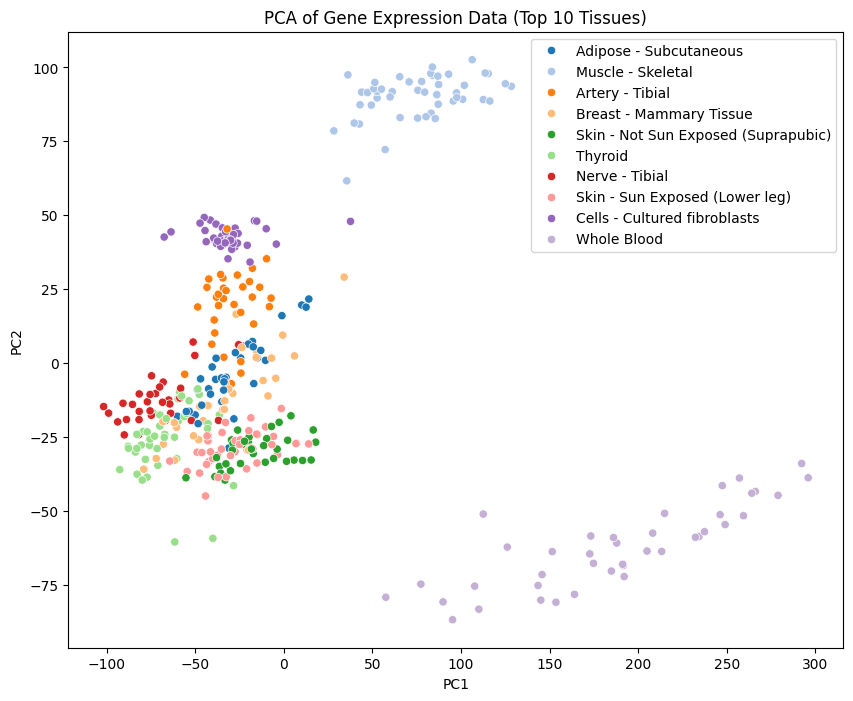

In [23]:
# Only for visualization purposes
_ = pca_analysis(n_PCA_components=2)

# PCA for training classifier (based on `n_PCA_components` principal components)
pca = pca_analysis(n_PCA_components=n_PCA_components)


### Display cumulative and explained variance<br>by the first `n_PCs_to_plot` principal components

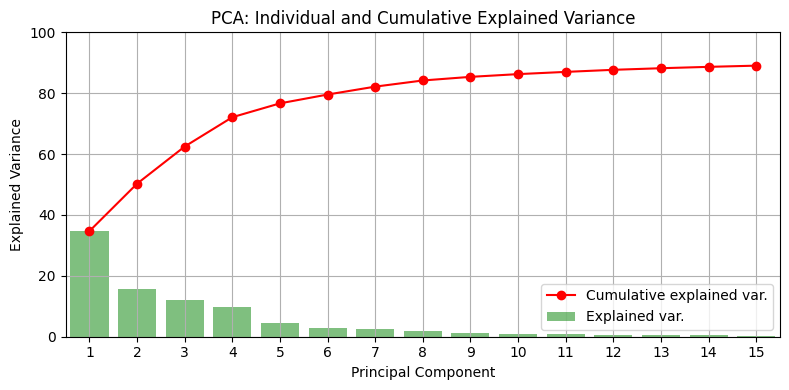

In [24]:
n_PCs_to_plot = 15
pca_var = PCA(n_components=n_PCs_to_plot).fit(X)
explained_var = 100*pca_var.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(8, 4))

# Explained var.
plt.bar(range(1, n_PCs_to_plot+1), explained_var, alpha=0.5, color='g', label='Explained var.')

# Cumulative explained var.
plt.plot(range(1, n_PCs_to_plot+1), cumulative_var, marker='o', color='r', label='Cumulative explained var.')

# Labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('PCA: Individual and Cumulative Explained Variance')
plt.xticks(range(1, n_PCs_to_plot+1)) 
plt.xlim((0.5,0.5+n_PCs_to_plot))
plt.ylim((0,100))
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid('both')
plt.show()


### Prepare training/test data for classifier

In [25]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# If 'X_pca = X' the classifier is trained on the "raw" data 
# (without using the PCA dimensionality reduction).
X_pca = pca.fit_transform(X)

# X: gene expressions
# y: tissue types / labels
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=SEED)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


### Define classifier

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier_PCA(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier_PCA, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

baseline_model = Classifier_PCA(input_size=X_train.shape[1], num_classes=num_classes)

### Classifier training

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=lr)

for epoch in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(train_loader):        
    scores = baseline_model(data)
    loss = criterion(scores, targets)        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Classifier evaluation

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

baseline_model.eval()  

all_preds = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        scores = baseline_model(data)
        _, predictions = scores.max(1)
        all_preds.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())


### Classifier accuracy

In [29]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

accuracy = check_accuracy(test_loader, baseline_model)
print(f'Accuracy: {100*accuracy:2.2f}[%]')

Accuracy: 90.79[%]


### Confusion Matrix

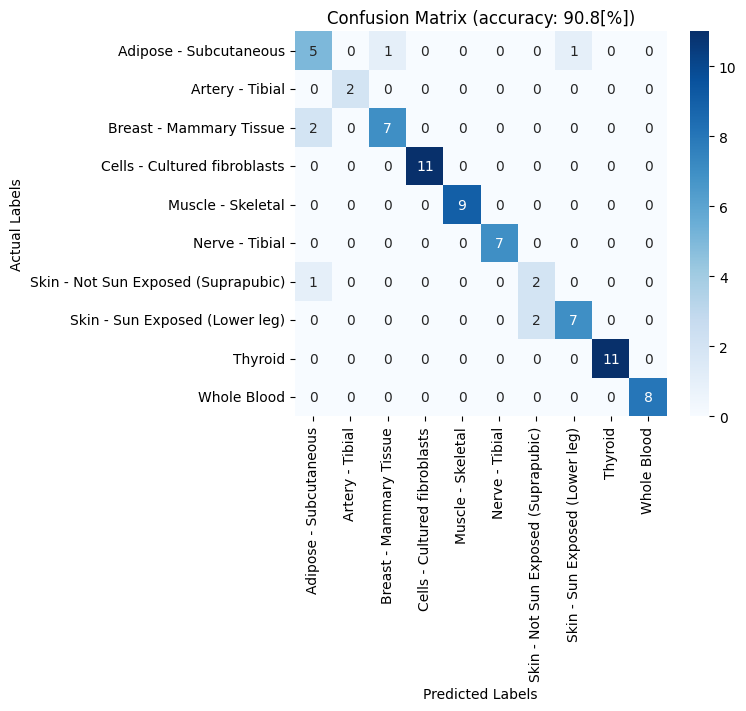

In [30]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (accuracy: {100*accuracy:2.1f}[%])')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Adjust the label ticks if necessary
tissue_types = label_encoder.classes_ 
plt.xticks(np.arange(num_classes) + 0.5, tissue_types, rotation=90)
plt.yticks(np.arange(num_classes) + 0.5, tissue_types, rotation=0)

plt.show()
